# Hair Segmentation 

In [52]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
collab = False

## Import dataset

Found 672 images belonging to 1 classes.
Found 672 images belonging to 1 classes.
Found 168 images belonging to 1 classes.
Found 168 images belonging to 1 classes.
Found 210 images belonging to 1 classes.
Found 210 images belonging to 1 classes.


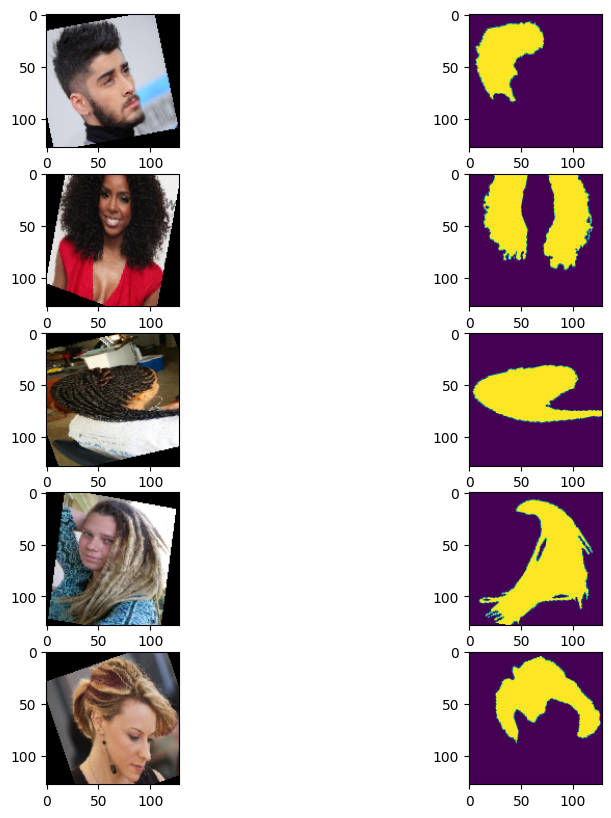

In [53]:
# define dataset dir path
if collab is False:
    root_dir = ''
else :
    root_dir = '/'
    #!unzip /Figaro1k.zip -d /


train_dir = os.path.join(root_dir, 'Figaro1k/Training')
test_dir = os.path.join(root_dir, 'Figaro1k/Testing')

# data augmentation
data_gen_args = dict(featurewise_center=False,
                     rescale = 1.0/255.0,
                     fill_mode = 'constant',
                     rotation_range=30,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     validation_split=0.2,
                     shear_range=0.2,
                     zoom_range=0.2)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 12345
batch_size = 32
#image_datagen.fit(X_train, augment=True, seed=seed)
#mask_datagen.fit(y_train[:,:,:,np.newaxis], augment=True, seed=seed)
image_train_generator = image_datagen.flow_from_directory(
    os.path.join(train_dir, 'imgs'),
    color_mode = "rgb",
    target_size=(128,128),
    class_mode=None,
    batch_size=batch_size,
    seed=seed,
    subset='training')

mask_train_generator = mask_datagen.flow_from_directory(
    os.path.join(train_dir, 'masks'),
    target_size=(128, 128), 
    batch_size=batch_size,
    color_mode = "grayscale",
    interpolation = "nearest",  
    class_mode=None,
    seed=seed,
    subset='training')

image_val_generator = image_datagen.flow_from_directory(
    os.path.join(train_dir, 'imgs'),
    color_mode = "rgb",
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode=None,
    seed=seed,
    subset='validation')

mask_val_generator = mask_datagen.flow_from_directory(
    os.path.join(train_dir, 'masks'),
    color_mode = "grayscale",
    interpolation = "nearest",
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode=None,
    seed=seed,
    subset='validation')


# combine generators into one which yields image and masks
train_generator = zip(image_train_generator, mask_train_generator)
val_generator = zip(image_val_generator, mask_val_generator)

fig = plt.figure(figsize=(10,10))
i = 0
for generator in train_generator:
    plt.subplot(5,2,1+2*i)
    plt.imshow(generator[0][i])
    plt.subplot(5,2,2+2*i)
    plt.imshow(generator[1][i][:,:,0])
    i += 1
    if i % 5 == 0:
        break

# Generator for test
image_test_datagen = ImageDataGenerator()
image_test_generator = image_test_datagen.flow_from_directory(
    os.path.join(test_dir, 'imgs'),
    color_mode = "rgb",
    target_size=(128,128),
    class_mode=None,
    shuffle=False,
    batch_size=batch_size)

# Gerator for test
mask_test_datagen = ImageDataGenerator()
mask_test_generator = mask_test_datagen.flow_from_directory(
    os.path.join(test_dir, 'masks'),
    color_mode = "grayscale",
    target_size=(128,128),
    class_mode=None,
    shuffle=False,
    batch_size=batch_size)

## Create CNN

In [54]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras.losses import BinaryCrossentropy


In [55]:
# Architecture from https://www.kaggle.com/code/rahuldshetty/hair-segmentation-using-u-net/notebook
inputs = Input((128, 128, 3))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
poo5a = MaxPooling2D(pool_size=(2, 2))(conv5)
conv5a = Conv2D(1024, (3, 3), activation='relu', padding='same')(poo5a)
conv5a = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5a)

In [56]:
up6a = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5a), conv5], axis=3)
conv6a = Conv2D(512, (3, 3), activation='relu', padding='same')(up6a)
conv6a = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6a)
up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6a), conv4], axis=3) #Was conv5 instead of conv6a
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
conv10 = Conv2D(1, (3, 3), activation='relu', padding='same')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])
model.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=['acc'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_46 (Conv2D)             (None, 128, 128, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_47 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_46[0][0]']              
                                )                                                           

## Train NN

In [57]:
#Create directory to save model and history
num_train = 0
while os.path.isdir(os.path.join(root_dir, 'training_{i}'.format(i=num_train))):
    num_train +=1
save_dir = os.path.join(root_dir, 'training_{i}'.format(i=num_train))
os.makedirs(save_dir)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-7)

#train model
epochs = 100
history = model.fit(train_generator,validation_data=val_generator,epochs=epochs,batch_size=batch_size, steps_per_epoch=len(image_train_generator), validation_steps=len(image_val_generator), callbacks=[reduce_lr])
#history = model.fit(train_generator,epochs=epochs,batch_size=64, steps_per_epoch=len(image_train_generator))
model.save(os.path.join(save_dir, 'model.h5'))
np.save(os.path.join(save_dir, 'my_history.npy') ,history)
    

Epoch 1/50
21/21 [==============================] - 5s 207ms/step - loss: 1.2386 - acc: 0.6169 - val_loss: 0.7006 - val_acc: 0.4750 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - 4s 190ms/step - loss: 0.7040 - acc: 0.6094 - val_loss: 0.6175 - val_acc: 0.6399 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - 4s 191ms/step - loss: 0.5555 - acc: 0.6603 - val_loss: 0.4835 - val_acc: 0.7353 - lr: 0.0010
Epoch 4/50
21/21 [==============================] - 4s 192ms/step - loss: 0.4667 - acc: 0.7326 - val_loss: 0.4703 - val_acc: 0.7290 - lr: 0.0010
Epoch 5/50
21/21 [==============================] - 4s 187ms/step - loss: 0.5125 - acc: 0.7444 - val_loss: 0.5201 - val_acc: 0.6669 - lr: 0.0010
Epoch 6/50
21/21 [==============================] - 4s 182ms/step - loss: 0.4592 - acc: 0.7404 - val_loss: 0.4802 - val_acc: 0.7295 - lr: 0.0010
Epoch 7/50
21/21 [==============================] - 4s 187ms/step - loss: 0.4475 - acc: 0.7674 - val_loss: 0.5307 - val_acc: 0.714

INFO:tensorflow:Assets written to: ram://56cda3ee-f2d9-4dc6-873d-c29629daccc4/assets


INFO:tensorflow:Assets written to: ram://56cda3ee-f2d9-4dc6-873d-c29629daccc4/assets


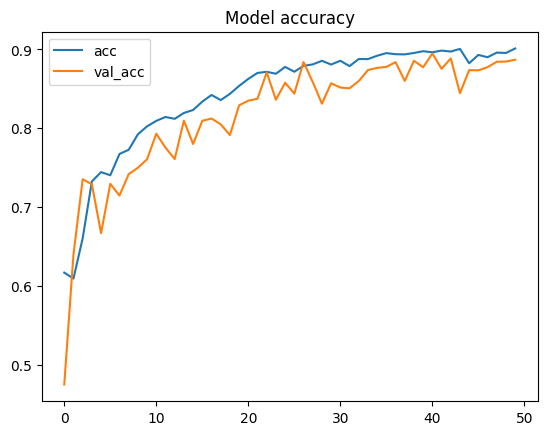

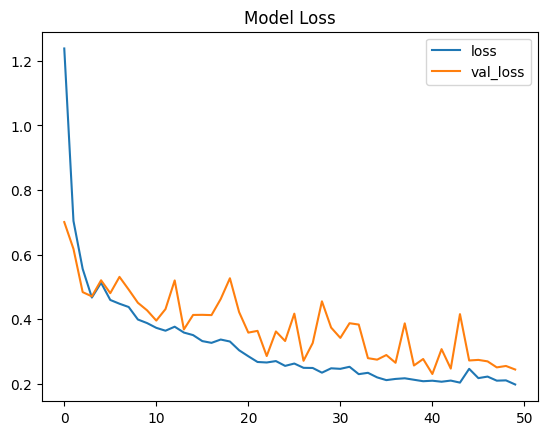

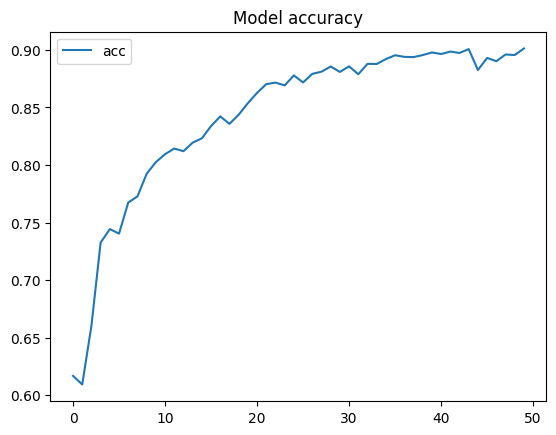

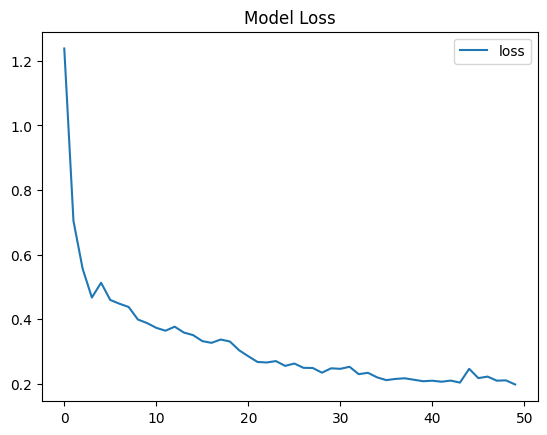

In [58]:
#history=np.load('bce_50epochs_conv6a_history.npy',allow_pickle='TRUE').item()

# Must have been training during this execution
h = history
plt.plot(h.history['acc'], label='acc')
plt.plot(h.history['val_acc'], label='val_acc')
plt.title('Model accuracy')
plt.legend()
plt.show()

plt.plot(h.history['loss'], label='loss')
plt.plot(h.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.legend()
plt.show()

plt.plot(h.history['acc'], label='acc')
plt.title('Model accuracy')
plt.legend()
plt.show()

plt.plot(h.history['loss'], label='loss')
plt.legend()
plt.title('Model Loss')
plt.show()

## Predict single image

### On training data

1/1 [==============================] - 0s 25ms/step - loss: 0.1409 - acc: 0.9314
accuacy :  0.931396484375


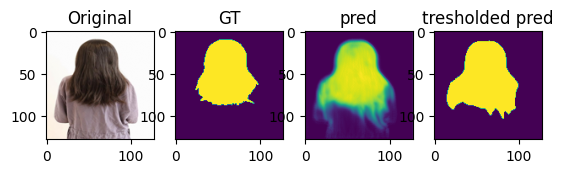

In [63]:
#Load trained model if necessary
#model = load_model('bce_50epochs_conv6a_model.h5')

idx = 10
img_dir = os.path.join(train_dir, 'imgs/Original')
images_names = sorted(os.listdir(img_dir))
msk_dir = os.path.join(train_dir, 'masks/GT')
masks_names = sorted(os.listdir(msk_dir))

img_path = os.path.join(img_dir, images_names[idx])
img = np.asarray(Image.open(img_path).resize((128,128)).convert('RGB'))/255.
mask_path = os.path.join(msk_dir, masks_names[idx])
mask = np.asarray(Image.open(mask_path).resize((128,128)).convert('L'))/255.


pred = model.predict(img[np.newaxis,:,:,:])

treshold = 0.5
#Get predicted masks
pred_mask = ((pred > treshold) * 255.)

fig, axes = plt.subplots(nrows=1, ncols=4)
plt.subplot(1,4,1)
plt.imshow(img)
plt.title("Original")
plt.subplot(1,4,2)
plt.imshow(mask)
plt.title("GT")
plt.subplot(1,4,3)
plt.imshow(pred[0])
plt.title("pred")
plt.subplot(1,4,4)
plt.imshow(pred_mask[0])
plt.title("tresholded pred")


score = model.evaluate(img[np.newaxis,:,:,:], mask[np.newaxis,:,:])
print("accuacy : ", score[1])

### On testing data

1/1 [==============================] - 0s 26ms/step - loss: 0.1563 - acc: 0.9432
accuacy :  0.9432373046875


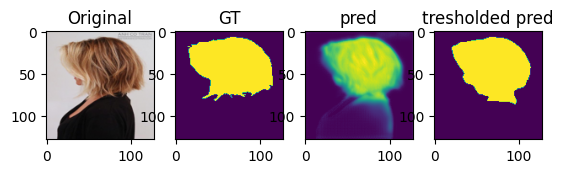

In [73]:
#Load trained model if necessary
#model = load_model('bce_50epochs_conv6a_model.h5')

idx = 5
img_dir = os.path.join(test_dir, 'imgs/Original')
images_names = sorted(os.listdir(img_dir))
msk_dir = os.path.join(test_dir, 'masks/GT')
masks_names = sorted(os.listdir(msk_dir))

img_path = os.path.join(img_dir, images_names[idx])
img = np.asarray(Image.open(img_path).resize((128,128)).convert('RGB'))/255.
mask_path = os.path.join(msk_dir, masks_names[idx])
mask = np.asarray(Image.open(mask_path).resize((128,128)).convert('L'))/255.


pred = model.predict(img[np.newaxis,:,:,:])

treshold = 0.5
#Get predicted masks
pred_mask = ((pred > treshold) * 255.)

fig, axes = plt.subplots(nrows=1, ncols=4)
plt.subplot(1,4,1)
plt.imshow(img)
plt.title("Original")
plt.subplot(1,4,2)
plt.imshow(mask)
plt.title("GT")
plt.subplot(1,4,3)
plt.imshow(pred[0])
plt.title("pred")
plt.subplot(1,4,4)
plt.imshow(pred_mask[0])
plt.title("tresholded pred")


score = model.evaluate(img[np.newaxis,:,:,:], mask[np.newaxis,:,:])
print("accuacy : ", score[1])

## Predict n first images

7/7 [==============================] - 0s 56ms/step


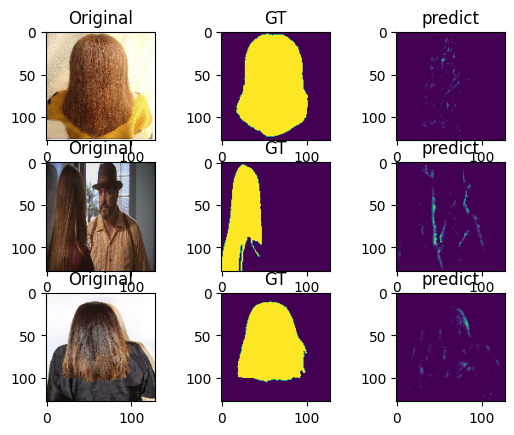

In [74]:
#Load trained model if necessary
#model = load_model('bce_50epochs_conv6a_model.h5')

n = 3

pred = model.predict(image_test_generator)
#Get predicted masks
treshold = 0.5
pred_mask = ((pred > treshold) * 255.)

fig, axes = plt.subplots(nrows=n, ncols=3)
for i in range(n*3):
    plt.subplot(3,3,i+1)
    if i % 3 == 0:
        plt.imshow(image_test_generator[0][i//3].astype(int))
        plt.title("Original")
    elif i % 3 == 1:
        plt.imshow(mask_test_generator[0][i//3])
        plt.title("GT")
    else:
        plt.imshow(pred[i//3])
        plt.title("predict")

In [75]:
#Evaluate model

score_train = model.evaluate(image_train_generator, mask_train_generator)
score_test = model.evaluate(image_test_generator, mask_test_generator)

print("accuracy on training set :", score_train[1])
print("accuracy on testing set :", score_test[1])

ValueError: `y` argument is not supported when using `keras.utils.Sequence` as input.